In [22]:
import numpy as np

In [1]:
import pandas as pd
from random import shuffle

In [2]:
import matplotlib.pyplot as plt

In [3]:
data_frame = pd.read_csv("./mnist_train.csv", sep=",", header=None)

In [4]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data_frame.loc[:, 1:] /= 255.0

In [6]:
tmp = data_frame.loc[1, :]

In [7]:
tmp[tmp != 0]

128    0.200000
129    0.623529
130    0.992157
131    0.623529
132    0.196078
155    0.188235
156    0.933333
157    0.988235
158    0.988235
159    0.988235
160    0.929412
182    0.211765
183    0.890196
184    0.992157
185    0.988235
186    0.937255
187    0.913725
188    0.988235
189    0.223529
190    0.023529
208    0.039216
209    0.235294
210    0.878431
211    0.988235
212    0.992157
213    0.988235
214    0.792157
215    0.329412
216    0.988235
217    0.992157
         ...   
577    0.874510
578    0.654902
579    0.219608
595    0.333333
596    0.988235
597    0.988235
598    0.988235
599    0.898039
600    0.843137
601    0.988235
602    0.988235
603    0.988235
604    0.768627
605    0.509804
623    0.109804
624    0.780392
625    0.988235
626    0.988235
627    0.992157
628    0.988235
629    0.988235
630    0.913725
631    0.568627
652    0.098039
653    0.501961
654    0.988235
655    0.992157
656    0.988235
657    0.552941
658    0.145098
Name: 1, Length: 176, dt

In [8]:
data=data_frame.as_matrix()

C:\Users\Paulina\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [9]:
image=data[0,1:].reshape((28,28))

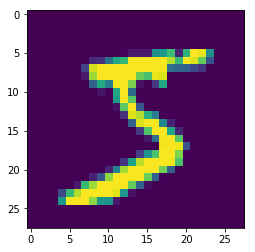

In [10]:
plt.imshow(image)
plt.show()

In [11]:
def show_image(data_matrix, index):
	image=data_matrix[index,1:].reshape((28,28))
	plt.imshow(image)
	plt.show()

In [12]:
data.shape

(60000, 785)

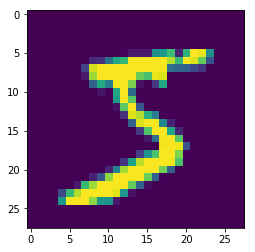

In [13]:
show_image(data, 0)

In [187]:
#create validation set
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(data, test_size=0.2, random_state=42)

from sklearn.metrics import mean_squared_error

In [951]:
class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, epochs,learning_rate = 0.05, activation_functions = None):
        self.number_of_classes = 10
        self.epochs=epochs
        self.train_data = train_data
        self.learning_rate = learning_rate
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(next_layer_num, current_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        self.bias_list = [np.random.randn(layer_num,1) for layer_num in self.neurons_num_per_layer[1:]]
        
    
    def main(self,batch_size):
        mse1=0
        avg_mse=np.zeros(train_data.shape[0])
        for epoch in range(self.epochs):
            shuffle(self.train_data)
            train_batches = self.create_train_batches(batch_size)
            mse1=self.feed_forward(train_batches,mse1)
            avg_mse[epoch]=mse1/train_data.shape[0]
                

    #uwaga feedforward można zrobić macierzowo, ale backprop trzeba dla pojedynczych rekordów
    def feed_forward(self, train_batches,mse):
        for train_batch in train_batches:
            print('jestem')
            labels = self.one_hot_encoded(train_batch[:, 0:1])
            train_batch_features = train_batch[:, 1:]
            batch_size=train_batch_features.shape[0]
        
            
            #forward
            grad_w=[]
            grad_b=[]
            
            for i in range (len(train_batch)): #rekord
                u = []
                layer_output = [train_batch_features[i,:]]
                for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                   
                    a=np.matmul(w,layer_output[-1])
                    
                    u.append(a.reshape(a.shape[0],1) + b)
                    print(u[-1].shape)
                    layer_output.append(activation_function(u[-1]))
                print(mean_squared_error(layer_output[-1],labels[:,i].reshape(10,1)))
                mse+=mean_squared_error(layer_output[-1],labels[:,i].reshape(10,1))
                
                #backprop
                label=labels[:,i].reshape(10,1)
                delta = [(layer_output[-1] - label) * self.softmax_derivative(layer_output[-1], u[-1])] 
                for layer_num in reversed(range(1, self.layers_num-1)):
                    delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1])*\
                                 self.sigmoid_derivative(u[layer_num-1])) 
                delta = list(reversed(delta))
                print('delta') 
                print(delta[0])
                print(delta[0].shape)
            
                
                print('tutu')
                print(delta[0].shape)
                print('fff')
                grad_w = [np.matmul(delta[0], train_batch_features[i,:].reshape(784,1).T)]
                #print(train_batch_features[i,:].reshape(784,1).T)
                #print(self.activation_functions)
                grad_b = delta.copy()
                for activ, d, _u in zip(self.activation_functions, delta[1:], u):
                    print(grad_w[-1])
                    grad_w.append(np.matmul(d,activ(_u).T))
                    
                
                grad_w=[x + y for x, y in zip(grad_w, grad_w)]
            new_weight_list = [w - (self.learning_rate * gw/batch_size) \
                               for w, gw in zip(self.weight_list, grad_w)]
            self.weight_list = new_weight_list
            
            new_bias_list = [ b - (self.learning_rate * gb/batch_size) \
                             for b, gb in zip(self.bias_list, grad_b)]
            self.bias_list = new_bias_list
        return mse
            
    def softmax_derivative(self, probabilities, u):
        diff_output=np.zeros([self.number_of_classes, self.number_of_classes])
        for row in range (diff_output.shape[0]):
            for col in range (diff_output.shape[1]):
                if (col==row):
                    diff_output[row,col]=probabilities[row,0]*(1-probabilities[col,0])
                else:
                    diff_output[row,col]=-probabilities[row,0]*probabilities[col,0]
        return np.matmul(diff_output,u)
                             
    def sigmoid_derivative(self, u):
        diff_output=u*(1-u)
        return diff_output
        
    def tanh_derivative(self, u):
        diff_output=1-(u)^2
        return diff_output
         
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        

In [952]:
net = Network(train_data[1:2], [3,2],10)

In [953]:
[matrix.shape for matrix in net.weight_list]

[(3, 784), (2, 3), (10, 2)]

In [954]:
net.input_neurons_num

784

In [955]:
net.bias_list[2].shape

(10, 1)

In [956]:
net.weight_list[0]

array([[ 0.2219037 , -0.68323557,  0.7387762 , ...,  1.33186049,
         1.16672196,  1.16947818],
       [ 1.25523836, -1.25553075,  0.01336647, ..., -0.12227322,
         0.57276017, -0.40640895],
       [ 0.77677399, -1.09476648,  1.66994066, ...,  0.56271939,
         0.42085313,  0.90418772]])

In [957]:
net.sigmoid_function(0)

0.5

In [958]:
net.layers_num

4

In [959]:
[matrix.shape for matrix in net.create_train_batches(2)]

[(1, 785)]

In [960]:
np.argmax(net.softmax_function(np.array([1,2,3])))

2

In [961]:
net.softmax_function(np.array([1,2,3]))

array([0.09003057, 0.24472847, 0.66524096])

In [962]:
net.one_hot_encoded(np.array([1,2,3,4]))

array([[0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [963]:
net.main(1)

jestem
(3, 1)
(2, 1)
(10, 1)
0.09079505195857256
delta
[[ 0.07356195]
 [ 0.1032869 ]
 [-1.54306994]]
(3, 1)
tutu
(3, 1)
fff
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.   

In [964]:
len(net.create_train_batches(2))

1

In [965]:
net.back_propagation(net.feed_forward(2))

AttributeError: 'Network' object has no attribute 'back_propagation'

In [880]:
def fun1 (s):
    s+=3
    return s
s=0
for i in range (4):
    s=fun1(s)

In [559]:
xy=[3,4,5]
[x + y for x, y in zip(xy,xy)]

[6, 8, 10]